# Capstone Workbook
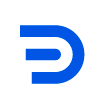
### In this Workbook, I will explore my cleaned data, creating insightful visualisations that relate to my hypothesis and prepare them for presentation

## Imports

In [45]:
!pip install https://github.com/elyase/geotext/archive/master.zip
!pip install topojson
!pip install country_converter --upgrade
!pip install plotly==5.0.0
!pip install millify
!pip install iso3166

  Using cached https://github.com/elyase/geotext/archive/master.zip


In [46]:
import os
import itertools
import collections
from collections import Counter
import re
import numpy as np

import tweepy as tw
import pandas as pd
import string
import ast

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import PIL
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px
from millify import millify
from geotext import GeoText
import json
import topojson
from urllib.request import urlopen
import country_converter as coco
from iso3166 import countries

In [47]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#import kaggle dataset
kaggle = pd.read_csv('/content/drive/MyDrive/Digital Futures/Capstone/covid19_tweets.csv')

In [50]:
kaggle

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False


## Functions

In [51]:
# Cleaning function
def tweet_clean(df):
# remove emojis from the text
    def remove_emoji(string):
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
# REGEX function   
    def regex_clean(txt, regex):
        return " ".join(re.sub(regex, "", txt).split())
# lemmatize tweet
    lemmatizer = WordNetLemmatizer()
    stpwrd = nltk.corpus.stopwords.words('english')
    stpwrd.extend(string.punctuation)
    def lemmatize_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [lemmatizer.lemmatize(word) for word in n]
        n = [lemmatizer.lemmatize(word) for word in n if word not in stpwrd]
        return n
# stem tweet
    p_stemmer = PorterStemmer()
    def stem_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [p_stemmer.stem(word) for word in n]
        n = [p_stemmer.stem(word) for word in n if word not in stpwrd]
        return n
# lancaster stem tweet
    def lanc_stemmed(df):
        df['split'] = df['cleaned'].apply(lambda x: str(x).lower())
        df['split'] = df.split
        df['split'].replace('^[0-9]+$','',inplace=True)
        for punc in string.punctuation:
            df['split'] = df.split.str.replace(punc,'')
        df['split'] = df['split'].apply(lambda x: [item for item in str(x).split() if item not in stopwords.words('english')])
        df['split'] = df['split'].apply(lambda x: [LancasterStemmer().stem(a) for a in x])
        return df

# apply cleaning functions to dataframe
# find all hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r"#(\w+)", x))
# clean dataframe
    df['cleaned'] = df['text'].apply(str.lower)
  
    regex_to_clean = ['(@.+?)\s',
                      '\s\d+\s']
    for reg in regex_to_clean:
        df['cleaned'] = df['cleaned'].apply(regex_clean, regex=reg)
        df['cleaned'] = df['cleaned'].apply(remove_emoji)
# tokenize tweet  
    df['tokens'] = df['cleaned'].apply(word_tokenize)
# lemmatize tweet  
    df['lemmatized'] = df['cleaned'].apply(lemmatize_data)
# stem tweet
    df['stemmed'] = df['cleaned'].apply(stem_data)
# lancaster stem tweet
    df = lanc_stemmed(df)
# return cleaned dataframe
    return df

## EDA

In [52]:
# clean dataset
kaggle = tweet_clean(kaggle)
kaggle

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,[],if i smelled the scent of hand sanitizers toda...,"[if, i, smelled, the, scent, of, hand, sanitiz...","[smelled, scent, hand, sanitizers, today, some...","[smell, scent, hand, sanit, today, someon, pas...","[smel, scent, hand, sanit, today, someon, past..."
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,[],hey and - wouldn't it have made more sense to ...,"[hey, and, -, would, n't, it, have, made, more...","[hey, would, n't, made, sense, player, pay, re...","[hey, would, n't, made, sen, player, pay, resp...","[hey, wouldnt, mad, sens, play, pay, respect, ..."
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,[COVID19],trump never once claimed #covid19 was a hoax. ...,"[trump, never, once, claimed, #, covid19, was,...","[trump, never, claimed, covid19, wa, hoax, cla...","[trump, never, onc, claim, covid19, wa, hoax, ...","[trump, nev, claim, covid19, hoax, claim, effo..."
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,[COVID19],the one gift #covid19 has give me is an apprec...,"[the, one, gift, #, covid19, has, give, me, is...","[one, gift, covid19, ha, give, appreciation, s...","[one, gift, covid19, ha, give, appreci, simpl,...","[on, gift, covid19, giv, apprecy, simpl, thing..."
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,"[CoronaVirusUpdates, COVID19]",25 july : media bulletin on novel #coronavirus...,"[25, july, :, media, bulletin, on, novel, #, c...","[25, july, medium, bulletin, novel, coronaviru...","[25, juli, media, bulletin, novel, coronavirus...","[25, july, med, bulletin, novel, coronavirusup..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False,[WearAMask],thanks for nominating me for the #wearamask ch...,"[thanks, for, nominating, me, for, the, #, wea...","[thanks, nominating, wearamask, challenge, nom...","[thank, nomin, wearamask, challeng, nomin, htt...","[thank, nomin, wearamask, challeng, nomin, htt..."
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False,[COVID19],2020! the year of insanity! lol! #covid19 http...,"[2020, !, the, year, of, insanity, !, lol, !, ...","[2020, year, insanity, lol, covid19, http, //t...","[2020, year, insan, lol, covid19, http, //t.co...","[2020, year, ins, lol, covid19, httpstcoy48np0..."
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False,[],a po

In [53]:
# download cleaned dataframe to csv
from google.colab import files
kaggle.to_csv('kaggle.csv')
files.download("kaggle.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# explore unique usernames
kaggle.user_name.nunique()

92276

# Conspiracy Hashtags

## Identify Conspiracy Hashtags

In [55]:
# fill any null hashtags with empty []
kaggle['hashtags'] = kaggle.hashtags.fillna('[]')

In [56]:
# explore data types
kaggle.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
hashtag             object
cleaned             object
tokens              object
lemmatized          object
stemmed             object
split               object
dtype: object

In [57]:
# define complete hashtags list (from 'Capstone Exploratory Analysis for Hashtags Workbook'): these are all the conspiratory hashtags 
complete_hashtags_list = ['chinaliedpeopledied', 'chinesevirus', 'fauci', 'lableaktheory', 'lableak', 'magneticpower', 'notocoronavirusvaccines', 'wuhanlab', 'ccp_is_terrorist', 'ccpbiowarfare', 'fakenewsalert', 'fbi', 'kungflu', 'plandemic', 'sideeffects', 'statemedia', 'surveillancestate', 'terrorism', 'terrorists', 'theliberalmediaistheenemy', 'vaccinesideeffects', 'covidbraindamage', 'disinformation', '5g', 'aliens', 'antivax', 'billgates', 'biologicalweapon', 'bioweapon', 'bioweapons', 'fakenews' 'capitalismisthevirus', 'ccp_is_terrorist', 'ccpliedpeopledied', 'chinamustpay', 'chinazi', 'deathsentenceforfauci', 'democratsarecorrupt', 'democratsareevil', 'fauciliedpeopledied', 'gatesfoundation', 'usaexposed', 'ccpvirus', 'hoax', 'bigpharma', 'chinaagenda', 'cyberattack', 'cybersecurity', 'cyberthreats', 'faucigate', 'communismisthevirus', 'fakenews', 'fakedemic', 'chinavirus', 'coverup', 'father_of_corona', 'fatherofcorona', 'moronavirus', 'plague', 'report_china', 'report_china_father_of_corona', 'reportchina', 'hydroxychloroquine', '5gmast', 'magnetic', 'batsoup', 'deepstate', 'covid19hoax', 'trumpvirus', 'qanon', 'capitolriots', 'greatawakening', 'microchip', 'microchips', 'freezerohedge', 'antivaxx', 'chineliedpeopledied', 'china_is_terrorist', 'wuhancoronavirus', 'wuhanchinavirus', 'fuckchina', 'depopulation', 'holdchinaaccountable', 'deepstatevirus', 'nukechina', 'bombchina', 'deathtochina','sorosvirus', 'israelvirus', 'nwovirus', 'gatesvirus', 'ciavirus', 'americavirus', 'masscontrol', 'anactofwar', 'actofwar', 'puppetstopower', 'deepstatevaccine', 'deepstatefauci', 'firefauci', 'enemyofthepeople', 'burn5gtowers', 'fiveg', '5gtowers', 'stop5g']

In [58]:
# function that will only return hashtags from complete_hashtags_list
def conspiracy(x):
    consp_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in complete_hashtags_list:
            consp_list = np.append(consp_list, [i])
    
    print(consp_list)
    return consp_list

In [59]:
# new column that returns the conspiracy hashtags
kaggle['hashtag_conspiracies'] = kaggle.hashtags.apply(conspiracy)

Streaming output truncated to the last 5000 lines.
[]
[]
[]
['TrumpVirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['TrumpVirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['TrumpVirus']
[]
[]
[]
[]
[]
['ChinaVirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Plandemic' 'Hoax']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [60]:
# new data frames with only the conspiracy theories in
k2 = kaggle[kaggle['hashtag_conspiracies'].str.len() != 0]

In [61]:
k2

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hashtag,cleaned,tokens,lemmatized,stemmed,split,hashtag_conspiracies
103,Thomas Faires,"Toronto, Ontario, Canada","...yup, still a husband, vegetarian, computer ...",2011-04-14 12:36:09,738,143,28004,False,2020-07-25 12:24:10,1.28% of the U.S. population is infected with ...,"['COVID19', 'TrumpVirus', 'MaskItOrCasket']",Twitter for iPhone,False,"[COVID19, TrumpVirus, MaskItOrCasket]",1.28% of the u.s. population is infected with ...,"[1.28, %, of, the, u.s., population, is, infec...","[1.28, u.s., population, infected, covid-19, c...","[1.28, u.s., popul, infect, covid-19, covid19,...","[128, us, pop, infect, covid19, covid19, trump...",[TrumpVirus]
184,Michael Schindele,"Sarasota, FL",Air Force Captain Veteran turned Entreprenuer ...,2009-11-22 04:35:41,10127,10231,992,False,2020-07-25 12:21:24,Dying WITH #COVID19 is not the same as\n\nDyin...,"['COVID19', 'COVID19', 'FakeNews', 'Democrats']",Twitter for iPhone,False,"[COVID19, COVID19, FakeNews, Democrats]",dying with #covid19 is not the same as dying f...,"[dying, with, #, covid19, is, not, the, same, ...","[dying, covid19, dying, covid19-, huge, differ...","[die, covid19, die, covid19-, huge, differ, fa...","[dying, covid19, dying, covid19, hug, diff, fa...",[FakeNews]
250,Ismael,"Chicago, IL",@RRCAnational & @USATF Level 1 Coach,2009-01-07 16:51:54,406,1721,30306,False,2020-07-25 12:19:18,Yes!\n#WakeUp #COVID19 #Fake #Plandemic #Exoso...,"['WakeUp', 'COVID19', 'Fake', 'Plandemic', 'Ex...",Twitter for Android,False,"[WakeUp, COVID19, Fake, Plandemic, Exosomes, V...",yes! #wakeup #covid19 #fake #plandemic #exosom...,"[yes, !, #, wakeup, #, covid19, #, fake, #, pl...","[yes, wakeup, covid19, fake, plandemic, exosom...","[ye, wakeup, covid19, fake, plandem, exosom, v...","[ye, wakeup, covid19, fak, plandem, exosom, vi...","[Plandemic, 5G]"
296,Abir Ballan,NaN,"BA in Psychology, Masters in Public Health, Dy...",2012-05-03 11:14:47,33,74,348,False,2020-07-25 12:17:49,@wodarg called for an inquiry into the influen...,"['BigPharma', 'WHO']",Twitter for iPhone,False,"[BigPharma, WHO]",called for an inquiry into the influence of #b...,"[called, for, an, inquiry, into, the, influenc...","[called, inquiry, influence, bigpharma, h1n1, ...","[call, inquiri, influenc, bigpharma, dure, h1n...","[cal, inquiry, influ, bigpharm, h1n1, pandem, ...",[BigPharma]
298,Albert Trigg,NaN,NaN,2015-05-19 21:22:44,3956,4531,24199,False,2020-07-25 12:17:48,A review of the recent study (now retracted) w...,"['5G', 'COVID19']",Twitter Web App,False,"[5G, COVID19]",a review of the recent study (now retracted) w...,"[a, review, of, the, recent, study, (, now, re...","[review, recent, study, retracted, connected, ...","[review, recent, studi, retract, connect, 5g, ...","[review, rec, study, retract, connect, 5g, cov...",[5G]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178758,Dee Tallman,NC🌊 by way of WV⛰ (USA),*LifelongDiehardDEMOCRAT *IStandWithImmigrants...,2013-03-18 19:49:57,15435,15520,135734,False,2020-08-29 20:02:29,RNC coronavirus rhetoric clashes with the fact...,"['COVID19', 'Coronavirus', 'RNC', 'TrumpVirus'...",Twitter for iPhone,False,"[COVID19, Coronavirus, RNC, TrumpVirus, Trump]",rnc coronavirus rhetoric clashes with the fact...,"[rnc, coronavirus, rhetoric, clashes, with, th...","[rnc, coronavirus, rhetoric, clash, fact, los,...","[rnc, coronaviru, rhetor, clash, fact, lo, ang...","[rnc, coronavir, rhet, clash, fact, los, angel...",[TrumpVirus]
178952,Pete Quily,"Vancouver, BC",Political & news acct. of information omnivore...,2011-02-03 06:49:07,6302,6563,1361,False,2020-08-29 19:53:17,@LaceyLaceyp Correct. As a White mask wearing ...,"['covid19', 'Disinformation']",Twitter Web App,False,"[covid19, Disinformation]","correct. as a white mask wearing person, this ...","[correct, ., as, a, white, mask, wea

## Lowercase Hashtags List

In [62]:
# lowercase all the hashtags
def lowercase(x):
    new_list = np.array([])
    
    for item in x:
        new_list = np.append(new_list, str.lower(item))
    
    return new_list

In [63]:
# new column in the conspiracy dataset with all the hashtags in lowercase
k2['hashtag_lower'] = k2.hashtag.apply(lowercase)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
# new column in the original dataset with all the hashtags in lowercase
kaggle['hashtag_lower'] = kaggle.hashtag.apply(lowercase)

In [65]:
# new column in the conspiracy dataset with all the conspiracy hashtags in lowercase
k2['conspiracies_lower'] = k2.hashtag_conspiracies.apply(lowercase)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
# new column in the original dataset with all the conspiracy hashtags in lowercase
kaggle['conspiracies_lower'] = kaggle.hashtag_conspiracies.apply(lowercase)

# Common Words and Word Clouds

## Word Clouds

In [67]:
# word cloud hashtags of conspiracy theories

hash_tag_counts = Counter()
k2['hashtag_lower'].apply(hash_tag_counts.update)

103       None
184       None
250       None
296       None
298       None
          ... 
178758    None
178952    None
179003    None
179072    None
179097    None
Name: hashtag_lower, Length: 1808, dtype: object

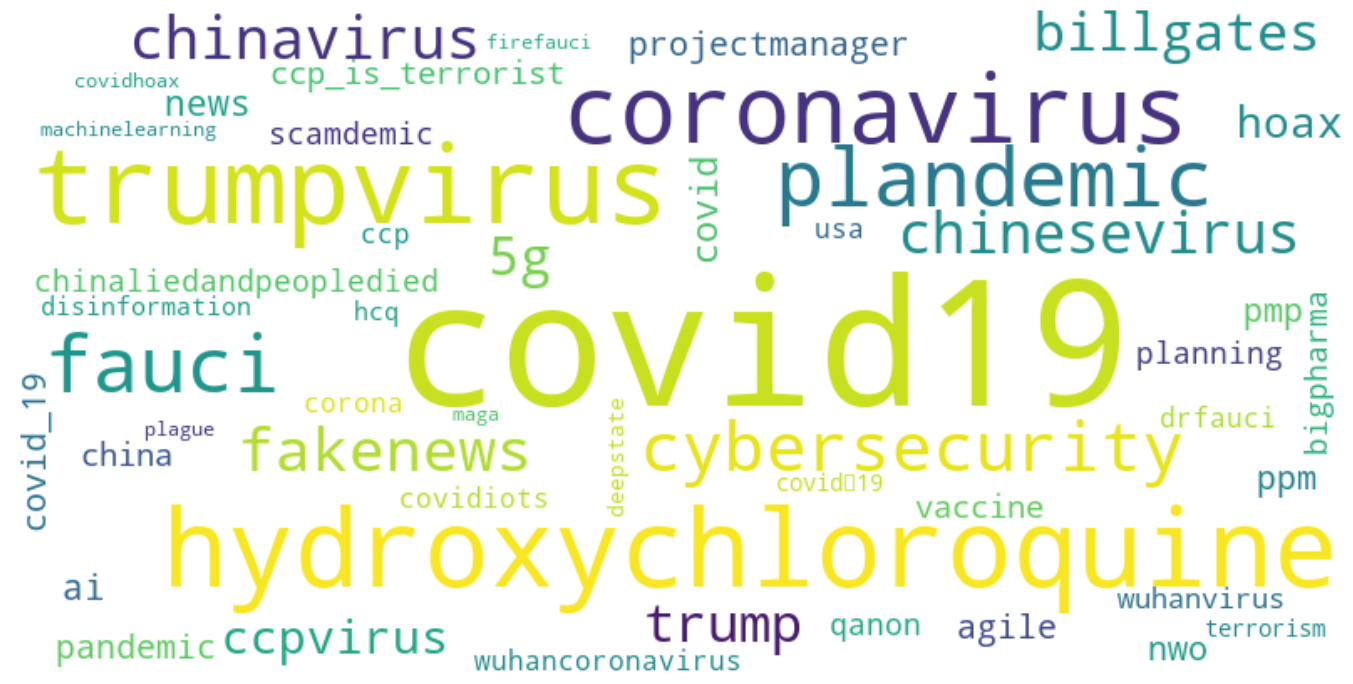

In [68]:
# word cloud of all the hashtags in the conspiracy dataset

wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(hash_tag_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [69]:
# word cloud tokens of conspiracy theories from tokenised text

token_counts = Counter()
k2['tokens'].apply(token_counts.update)

103       None
184       None
250       None
296       None
298       None
          ... 
178758    None
178952    None
179003    None
179072    None
179097    None
Name: tokens, Length: 1808, dtype: object

In [70]:
# extend stopwords to include punctuation and https
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend(['https'])

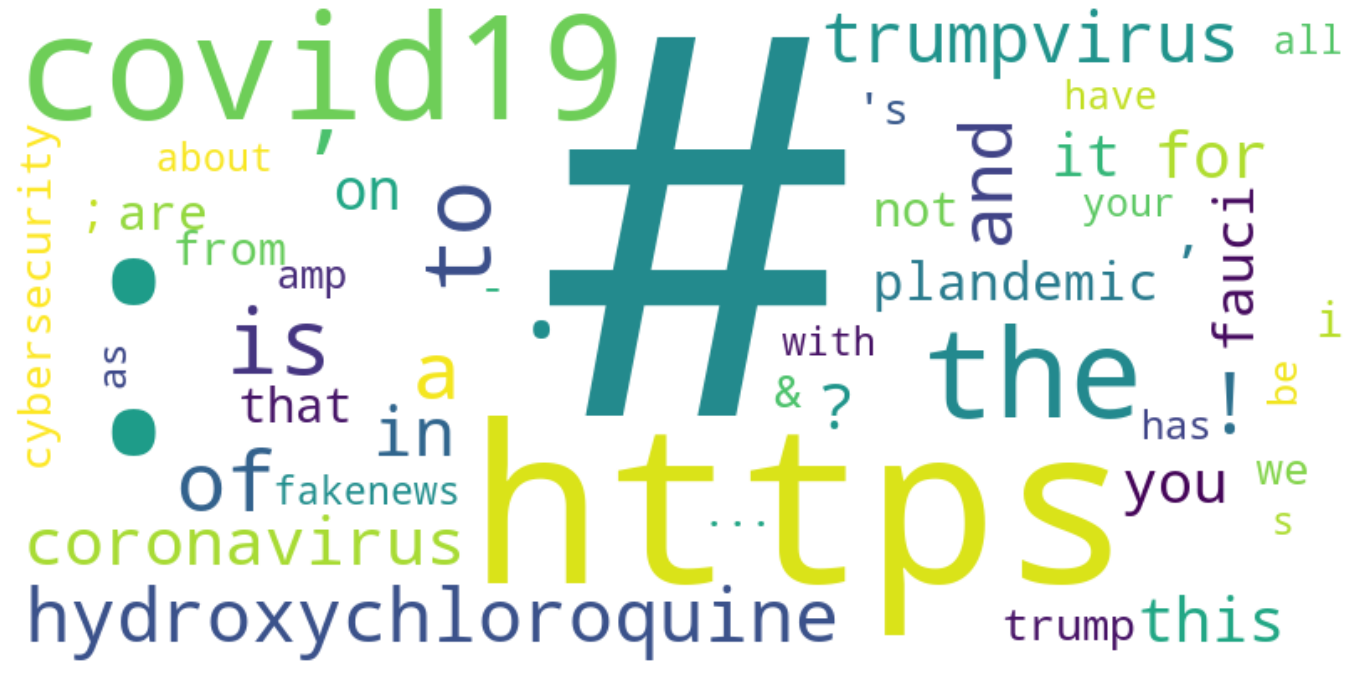

In [71]:
wc = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=stpwrd, collocations='False').generate_from_frequencies(token_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [72]:
## word cloud tokens of conspiracy theories from lemmatized text
lemma_counts = Counter()
k2['lemmatized'].apply(lemma_counts.update)

103       None
184       None
250       None
296       None
298       None
          ... 
178758    None
178952    None
179003    None
179072    None
179097    None
Name: lemmatized, Length: 1808, dtype: object

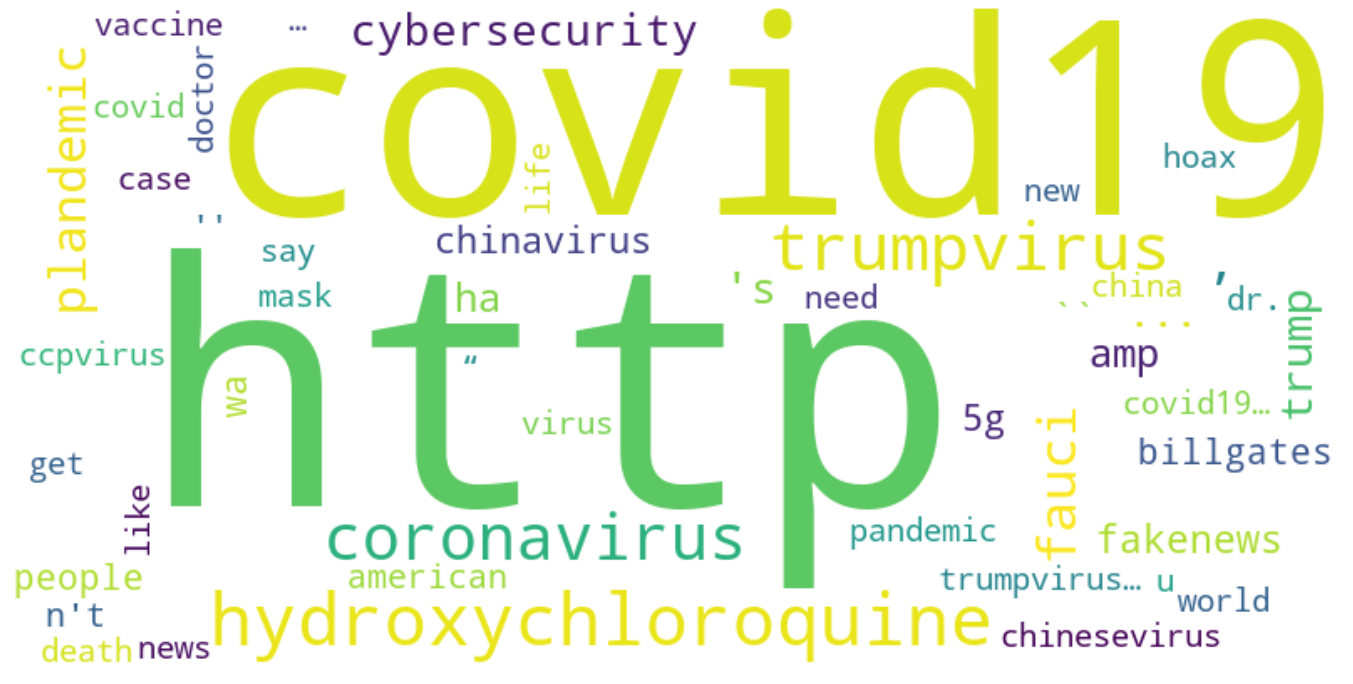

In [73]:
wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(lemma_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [74]:
## word cloud tokens of conspiracy theories from stemmed text
stem_counts = Counter()
k2['stemmed'].apply(stem_counts.update)

103       None
184       None
250       None
296       None
298       None
          ... 
178758    None
178952    None
179003    None
179072    None
179097    None
Name: stemmed, Length: 1808, dtype: object

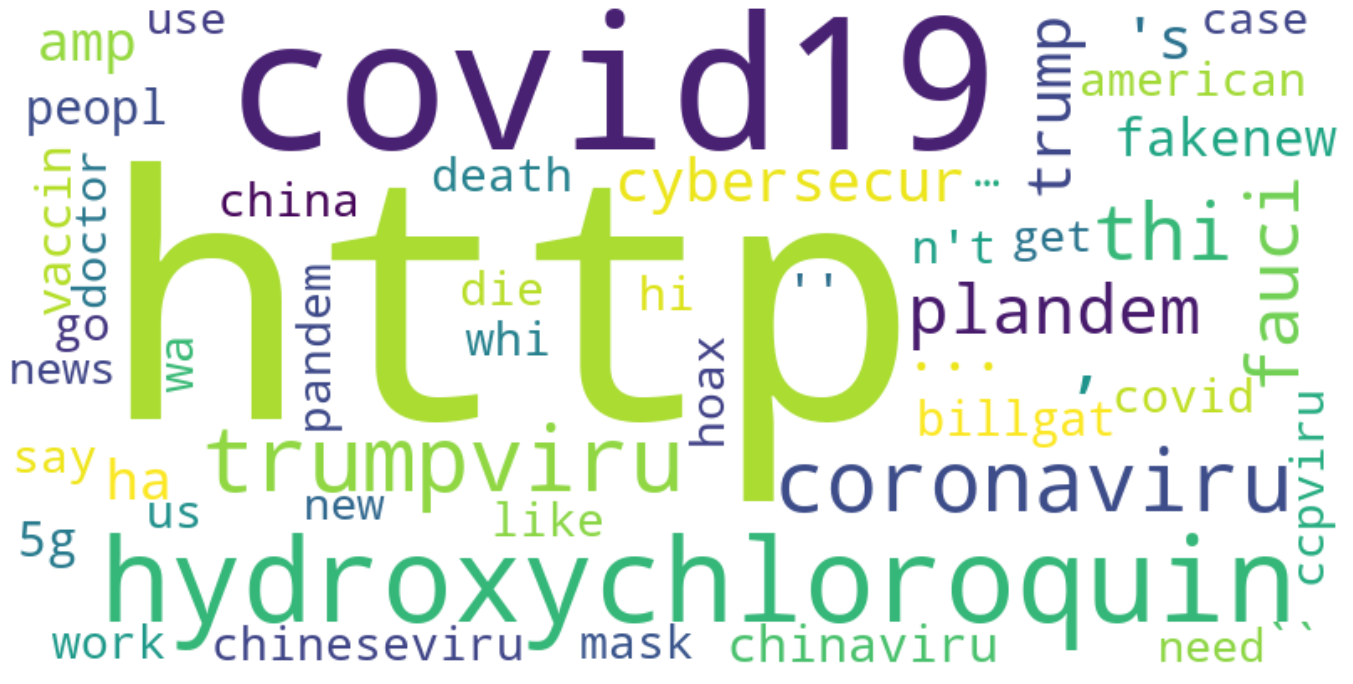

In [75]:
wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(stem_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Top hashtags

In [76]:
# top used hashtags and count from original dataset
words_in_hashtag_all = [tweet for tweet in kaggle.hashtag_lower]
words_in_hashtag_all2 = list(itertools.chain(*words_in_hashtag_all))
counts_hashtag_all = collections.Counter(words_in_hashtag_all2)
counts_hashtag_all.most_common(1000)
clean_counts_all = pd.DataFrame(counts_hashtag_all.most_common(1000),
                                    columns=['hashtags', 'count'])
clean_counts_all

,hashtags,count
0,covid19,100312
1,coronavirus,10198
2,pandemic,1625
3,covid,1300
4,india,1193
...,...,...
995,drawing,21
996,training,21
997,shutdown,21
998,manipur,21


In [77]:
# bar graph top used hashtags and count from original dataset
Count_graph=px.bar(x='hashtags',
                   y='count',
                   data_frame=clean_counts_all[:33],
                   text='count',
                   color='hashtags',
                   title='Top 10 Most Common Used Hashtags',
                   height=600,
                   width=1000,
                   orientation='v',
                   labels={"hashtags": "Hashtags", "count": "Count of Tweets"}
                   )
Count_graph.update_traces(texttemplate='%{text:.2s}', textposition='outside')
Count_graph.show()

## Top conspiracy hashtags

In [78]:
# top used hashtags and count from conspiracy dataset
words_in_hashtag = [tweet for tweet in k2.hashtag_lower]
words_in_hashtag2 = list(itertools.chain(*words_in_hashtag))
counts_hashtag = collections.Counter(words_in_hashtag2)
counts_hashtag.most_common(1000)
clean_counts = pd.DataFrame(counts_hashtag.most_common(1000),
                                    columns=['hashtags', 'count'])
clean_counts

,hashtags,count
0,covid19,1276
1,hydroxychloroquine,337
2,trumpvirus,325
3,coronavirus,239
4,plandemic,179
...,...,...
995,scomo,1
996,covid19india,1
997,coronapandemic,1
998,limengyan,1


In [79]:
clean_counts.head(15)

,hashtags,count
0,covid19,1276
1,hydroxychloroquine,337
2,trumpvirus,325
3,coronavirus,239
4,plandemic,179
5,fauci,162
6,cybersecurity,124
7,fakenews,92
8,chinavirus,87
9,chinesevirus,83


In [80]:
# bar graph showing top used hashtags and count from conspiracy dataset
Count_graph=px.bar(x='hashtags',
                   y='count',
                   data_frame=clean_counts[:50],
                   text='count',
                   color='hashtags',
                   title='Common Hashtags in Conspiracy Tweets'
                   )
Count_graph.update_traces(texttemplate='%{text:.2s}', textposition='outside')
Count_graph.show()

## List of all hashtags

In [81]:
# Create List with all hashtags in
def hashtags(df):

    hashtag_list = []

    for item in df:
        for value in item:
            hashtag_list.append(value)

    return hashtag_list

In [82]:
# list of all hashtags in conspiracy dataset
# explore list
hashtags_list = hashtags(k2.hashtag)
hashtags_list[:15]

['COVID19',
 'TrumpVirus',
 'MaskItOrCasket',
 'COVID19',
 'COVID19',
 'FakeNews',
 'Democrats',
 'WakeUp',
 'COVID19',
 'Fake',
 'Plandemic',
 'Exosomes',
 'VirusTheory',
 '5G',
 'Virus']

## Original Data Word Cloud

In [83]:
# lowercase all hashtags
kaggle['hashtag_lower'] = kaggle.hashtag.apply(lowercase)

In [84]:
# word cloud of all the hashtags lowercased in the kaggle dataset
full_hashtags_counts = Counter()
kaggle['hashtag_lower'].apply(full_hashtags_counts.update)

0         None
1         None
2         None
3         None
4         None
          ... 
179103    None
179104    None
179105    None
179106    None
179107    None
Name: hashtag_lower, Length: 179108, dtype: object

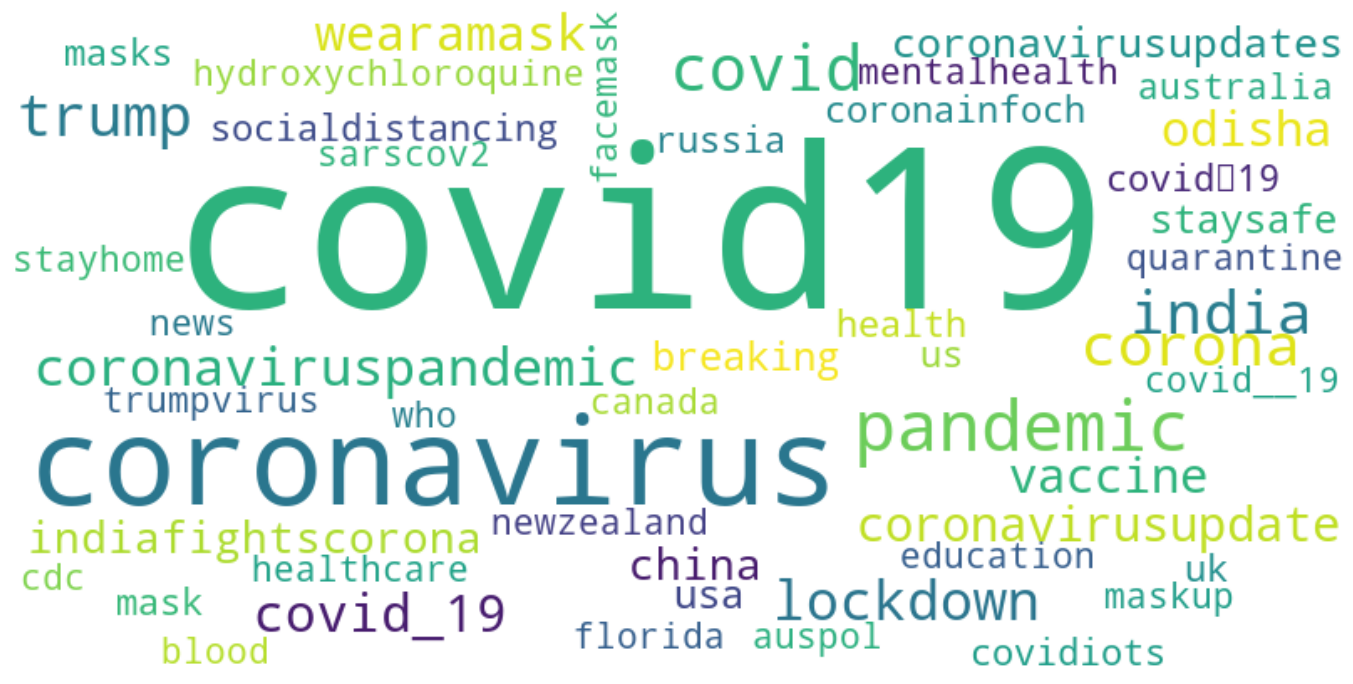

In [85]:
wc = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(full_hashtags_counts)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Twitter Mask

In [86]:
# twitter mask for word cloud
twitter_mask = np.array(Image.open("/content/drive/MyDrive/Digital Futures/Capstone/M2jeo.jpg"))
twitter_mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [87]:
# identify colors for wordcloud
colors = ["navy", "#0B32FF", "blue", "skyblue", "teal", "#9D32FF"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

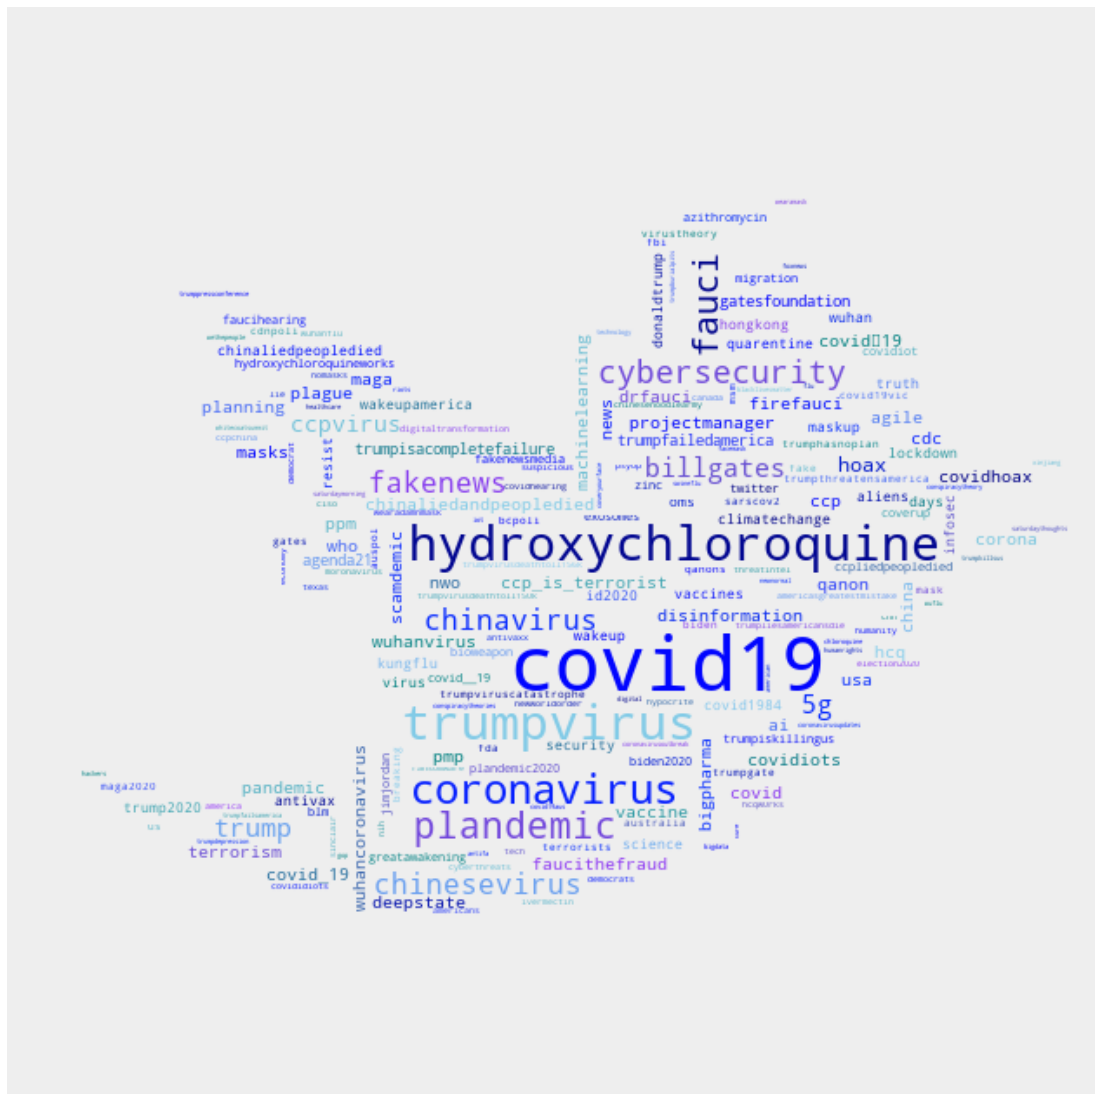

In [88]:
# word cloud of conspiracy hashtags
wc = WordCloud(width = 600, height = 400, random_state=1, background_color='#eeeeeeff', colormap=cmap , mask=twitter_mask, collocations=True).generate_from_frequencies(hash_tag_counts)
plt.figure(figsize=[20,20])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('tweetswc.png')
plt.show()


In [106]:
# covid mask for word cloud
virus_mask = np.array(Image.open("/content/drive/MyDrive/Digital Futures/Capstone/imageedit_13_7012571348.png"))
virus_mask = np.invert(virus_mask)

In [98]:
# identify colors for wordcloud
colors = ["black", "grey", "lightgrey", "maroon", "red"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

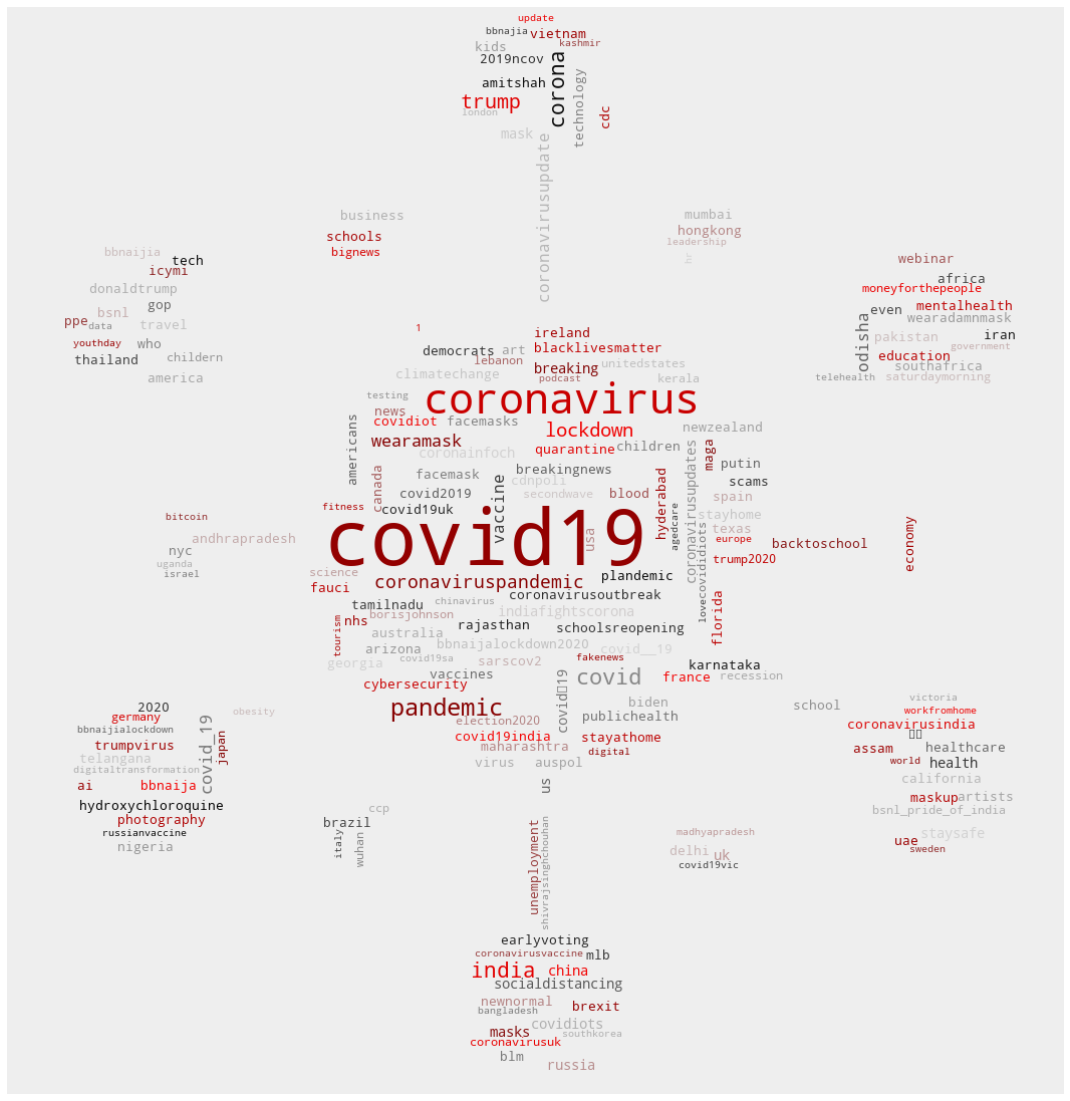

In [105]:
# word cloud of text used in conspiratory dataset 
wc = WordCloud(width = 400, height = 300, random_state=1, background_color='#eeeeeeff', colormap=cmap , mask=virus_mask, collocations=True).generate_from_frequencies(full_hashtags_counts)
plt.figure(figsize=[20,20])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('tweetswc.png')
plt.show()

## Reset k2 Dataframe

In [ ]:
# reset index
k2 = k2.reset_index()
k2

# Countries

## Location list

In [ ]:
# Create List with all hashtags in
def location(df):

    location_list = []

    for item in df:
        location_list.append(item)

    return location_list

In [ ]:
# explore list of locations
location_list = location(k2.user_location)

In [ ]:
# fill nulls with noe
k2.user_location = k2.user_location.fillna('None')

## K2 location count

In [ ]:
# new dataframe with location count of k2
location_count = pd.DataFrame(k2['user_location'].value_counts())
location_count.reset_index(inplace=True)
location_count.rename(columns={'index':'Location','user_location':'count'},inplace=True)
location_count.sort_values(by='count',inplace=True,ascending=False)

In [ ]:
# bar plot of location count
sns.barplot(data = location_count[:15],
            x = 'count', #column names
            y = 'Location', # column names 
            palette = 'colorblind',
            hue = 'Location',
            capsize = 0.5,
            saturation = 8)

plt.xlabel('Count of Tweets',
           fontsize = '5',
           fontweight = 'bold')

plt.ylabel('Location',
           fontsize = '5',
           fontweight = 'bold')

plt.title('Location / Count of Tweets',
          fontsize = '5',
          fontweight = 'bold')

plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight ='normal',
           fontsize ='large',
           fontfamily = 'sans-serif')

plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()

## Kaggle location count

In [ ]:
# create new dataframe with the value counts of user location from the original kaggle dataset
location_all = pd.DataFrame(kaggle['user_location'].value_counts())
location_all.reset_index(inplace=True)
location_all.rename(columns={'index':'Location','user_location':'count'},inplace=True)
location_all.sort_values(by='count',inplace=True,ascending=False)

In [ ]:
# aggregate values
location_all['Location']=location_all['Location'].apply(lambda x:x[2:-2])

In [ ]:
# bar plot of location count for kaggle
sns.barplot(data = location_all[:15],
            x = 'count', #column names
            y = 'Location', # column names 
            palette = 'colorblind',
            hue = 'Location',
            capsize = 0.5,
            saturation = 8)

plt.xlabel('Count of Tweets',
           fontsize = '5',
           fontweight = 'bold')

plt.ylabel('Location',
           fontsize = '5',
           fontweight = 'bold')

plt.title('Location / Count of Tweets',
          fontsize = '5',
          fontweight = 'bold')

plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight ='normal',
           fontsize ='large',
           fontfamily = 'sans-serif')

plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()

## K2 GeoLocation Data

In [ ]:
# create new dataframe location_country_code and replace location with GeoText of country  
location_country_code = location_count.copy()
location_country_code['Location']=location_country_code['Location'].apply(lambda x:x.replace(',',' '))
location_country_code['Location']=location_country_code['Location'].apply(lambda x:(GeoText(x).country_mentions))

In [ ]:
location_country_code

In [ ]:
location_country_code.drop(location_country_code[location_country_code['Location']=='[]'].index,inplace=True)
location_country_code['Location']=location_country_code['Location'].apply(lambda x:(x.keys()))
location_country_code['Location']=location_country_code['Location'].apply(lambda x:list(x))
location_country_code.drop(location_country_code.index[location_country_code.Location.map(len)==0],inplace=True)
location_country_code['Location']=location_country_code['Location'].apply(lambda x:str(x[0]))

In [ ]:
agg_func={'count':'sum'}
location_country_code=location_country_code.groupby(['Location']).aggregate(agg_func)

In [ ]:
location_country_code

In [ ]:
# sort locations by count
location_country_code.sort_values(by=['count'],ascending=False,inplace=True)
location_country_code.reset_index(inplace=True)
location_country_code.columns

In [ ]:
# convert country codes to GeoLocation data
cc = coco.CountryConverter()
location_country_code['Location']=location_country_code['Location'].apply(lambda x:cc.convert(names=x,to='ISO3'))

In [ ]:
# create bar graph that counts tweets containing conpsiracy theories according to country
Count_graph=px.bar(x='Location',
                   y='count',
                   data_frame=location_country_code[:10],
                   labels={"count": "Count of Tweets"},
                   title='Count of Tweets containing conpsiracy theories, hate speech or incitements to violence relating to COVID-19 according to Country',
                   text='count',
                   color_discrete_sequence=['#B0E0E6', '#5F9EA0', '#4682B4', '#6495ED', '#00BFFF', '#1E90FF', '#87CEFA', '#4169E1', '#0000FF', '#191970', '#4B0082', '#6A5ACD', '#8B008B', '#8A2BE2', '#BA55D3'],
                   color='Location',
                   height=800,
                   width=1200)
Count_graph.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)', 
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
Count_graph.show()

In [ ]:
location_country_code['count'].sum()

## Kaggle GeoLocation Data

In [ ]:
# do same as above, but with kaggle original dataset rather than conspiracies dataset
location_code_all = location_all.copy()
location_code_all['Location']=location_code_all['Location'].apply(lambda x:x.replace(',',' '))
location_code_all['Location']=location_code_all['Location'].apply(lambda x:(GeoText(x).country_mentions))

In [ ]:
location_code_all.drop(location_code_all[location_code_all['Location']=='[]'].index,inplace=True)
location_code_all['Location']=location_code_all['Location'].apply(lambda x:(x.keys()))
location_code_all['Location']=location_code_all['Location'].apply(lambda x:list(x))
location_code_all.drop(location_code_all.index[location_code_all.Location.map(len)==0],inplace=True)
location_code_all['Location']=location_code_all['Location'].apply(lambda x:str(x[0]))

In [ ]:
agg_func={'count':'sum'}
location_code_all=location_code_all.groupby(['Location']).aggregate(agg_func)

In [ ]:
location_code_all.sort_values(by=['count'],ascending=False,inplace=True)
location_code_all.reset_index(inplace=True)
location_code_all.columns

In [ ]:
cc = coco.CountryConverter()
location_code_all['Location']=location_code_all['Location'].apply(lambda x:cc.convert(names=x,to='ISO3'))

In [ ]:
Count_graph=px.bar(x='Location',
                   y='count',
                   data_frame=location_code_all[:10],
                   color='Location',
                   labels={"count": "Count of Tweets"},
                   title='Count of Tweets according to Country',
                   text='count',
                   color_discrete_sequence=['#191970', '#0000FF', '#4169E1', '#87CEFA', '#1E90FF', '#00BFFF', '#6495ED', '#4682B4', '#5F9EA0', '#B0E0E6', '#BA55D3','#8A2BE2', '#8B008B', '#6A5ACD', '#4B0082'],
                   height=800,
                   width=1200
                   )
Count_graph.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)', 
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
Count_graph.show()

## Tweets in the World

In [ ]:
# load geo.json countries
with urlopen('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json') as response:
    countries = json.load(response)

In [ ]:
location_code_all

In [ ]:
# correlate location code with geo.json countries and create chloropleth map for kaggle dataet
# this shows overall count of tweets across the world
fig = px.choropleth(data_frame=location_code_all,
                    geojson=countries,
                    locations="Location",
                    color="count",
                    hover_data=["count"],
                    # color_continuous_scale="tealgrn",
                    color_continuous_scale = [[0,"rgb(220, 220, 220)"], [0.35,"rgb(106, 137, 247)"], [0.5,"rgb(90, 120, 225)"], [0.6,"rgb(70, 100, 205)"], [0.7,"rgb(40, 90, 140)"], [1,"rgb(9, 74, 129)"]],
                    #["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1", "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be"],
                    title="Tweet Count per country",
                    labels={'count':'Tweet Count'}
                    )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'}, margin={"r":0,"t":0,"l":0,"b":0})
# paper_bgcolor="black"
fig.show()

In [ ]:
# create pie chart for count and location with kaggle dataset (location_code_all)
# this shows overall count of tweets across the world
fig = px.pie(location_code_all, 
             values='count', 
             names='Location',
             color_discrete_sequence = ['#191970', '#0000FF', '#4169E1', '#87CEFA', '#1E90FF', '#00BFFF', '#6495ED', '#4682B4', '#5F9EA0', '#B0E0E6', '#BA55D3','#8A2BE2', '#8B008B', '#6A5ACD', '#4B0082']
             )
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

In [ ]:
# correlate location code with geo.json countries and create chloropleth map for k2 dataet
# this shows  count of conspiratory tweets across the world
fig2 = px.choropleth(data_frame=location_country_code,
                    geojson=countries,
                    locations="Location",
                    color="count",
                    hover_data=["count"],
                    color_continuous_scale = [[0,"rgb(220, 220, 220)"], [0.35,"rgb(106, 137, 247)"], [0.5,"rgb(90, 120, 225)"], [0.6,"rgb(70, 100, 205)"], [0.7,"rgb(40, 90, 140)"], [1,"rgb(9, 74, 129)"]],
                    title="Tweet Count per country",
                    labels={'count':'Tweet Count'}
                    )
fig2.update_geos(fitbounds="locations", visible=False, lataxis_showgrid=True, lonaxis_showgrid=True)
fig2.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'}, margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

In [ ]:
# create pie chart for count and location with conspiracy dataset (location_country_code)
# this shows count of conspiratory tweets across the world
fig = px.pie(location_country_code, 
             values='count', 
             names='Location',
             color_discrete_sequence = ['#191970', '#0000FF', '#4169E1', '#87CEFA', '#1E90FF', '#00BFFF', '#6495ED', '#4682B4', '#5F9EA0', '#B0E0E6', '#BA55D3','#8A2BE2', '#8B008B', '#6A5ACD', '#4B0082']
             )
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()


# Tweets and User Count

## User name count
Resources Used: 

https://www.kaggle.com/isaienkov/covid19-dynamic-in-time-and-space-of-the-tweets#notebook-container

https://www.kaggle.com/raenish/covid19-tweets/execution

https://www.kaggle.com/homayoonkhadivi/covid-19-tweets-eda-wordcloud-sentiment-analysis#Data-Visualization

https://www.kaggle.com/renjithrrkj/covid-19-tweets-analysis/data?select=countries.geo.json

In [ ]:
# create new dataframe username_count_all with value_counts of the user name in the whole kaggle dataset
username_count_all = kaggle['user_name'].value_counts().reset_index().rename(columns={
    'user_name':'tweet_count','index':'user_name'})

In [ ]:
# merge this dataframe with the kaggle dataset
kaggle = pd.merge(kaggle, username_count_all, on='user_name')

In [ ]:
# create bar plot which shows user names by top followers in original data set
data = kaggle.sort_values('user_followers',ascending=False).drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'user_followers', 'tweet_count']]
data.sort_values('user_followers',ascending=False)

data1 = data.head(50).reset_index().copy()
for i in range(50):
    data1['user_followers'][i] = millify(data1['user_followers'][i],precision=2)
    
data1['user_followers'] = data1['user_followers'].str[:-1].astype(float) # To remove 'M'

plt.figure(figsize=(15, 17))
sns.barplot(y='user_name',x='user_followers',data=data1.head(50))
y=data1['user_followers'].head(50)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Top50 users by number of followers',weight='bold', size=15)
plt.ylabel('User_name', size=12, weight='bold')
plt.xlabel('Followers_count( in Millions )', size=12, weight='bold')
plt.show()

In [ ]:
# create bar plot which shows user names by top number of tweets in original data set

data = kaggle.sort_values('tweet_count',ascending=False).drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'tweet_count']]
data.sort_values('tweet_count',ascending=False)

data1 = data.head(10).reset_index().copy()
for i in range(10):
    data1['tweet_count'][i] = millify(data1['tweet_count'][i],precision=2)
    
# data1['tweet_count'] = data1['tweet_count'].str[:-1].astype(float) # To remove 'M'

plt.figure(figsize=(15, 17))
sns.barplot(y='user_name',x='tweet_count',data=data1.head(50))
y=data1['tweet_count'].head(10)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Top 10 users by number of Tweets',weight='bold', size=15)
plt.ylabel('User_name', size=12, weight='bold')
plt.xlabel('Tweets_count', size=12, weight='bold')
plt.savefig('users.png', transparent=True)
plt.show()

In [ ]:
# create new dataframe username_count_all with value_counts of the user name in the conspiracy dataset k2
username_count = k2['user_name'].value_counts().reset_index().rename(columns={
    'user_name':'tweet_count','index':'user_name'})

In [ ]:
# merge this dataframe with the conspiracy dataset k2
k2 = pd.merge(k2, username_count, on='user_name')

In [ ]:
# create bar plot which shows user names by top followers in conspiracy data set
data = k2.sort_values('user_followers',ascending=False).drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'user_followers', 'tweet_count']]
data.sort_values('user_followers',ascending=False)

data1 = data.head(10).reset_index().copy()
for i in range(10):
    data1['user_followers'][i] = millify(data1['user_followers'][i],precision=2)
    
data1['user_followers'] = data1['user_followers'].str[:-1].astype(float) # To remove 'M'

plt.figure(figsize=(15, 17))
sns.barplot(y='user_name',x='user_followers', data=data1.head(10))
y=data1['user_followers'].head(10)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Top 15 users by number of followers',weight='bold', size=15)
plt.ylabel('User_name', size=12, weight='bold')
plt.xlabel('Followers_count( in Millions )', size=12, weight='bold')
plt.show()

In [ ]:
# create bar plot which shows user names by top number of tweets in conspiracy data set
data = k2.sort_values('tweet_count',ascending=False).drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'tweet_count']]
data.sort_values('tweet_count',ascending=False)

data1 = data.head(15).reset_index().copy()
for i in range(15):
    data1['tweet_count'][i] = millify(data1['tweet_count'][i],precision=2)
    
# data1['tweet_count'] = data1['tweet_count'].str[:-1].astype(float) # To remove 'M'

plt.figure(figsize=(15, 17))
sns.barplot(y='user_name',x='tweet_count',data=data1.head(15))
y=data1['tweet_count'].head(15)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Top50 users by number of Tweets',weight='bold', size=15)
plt.ylabel('User_name', size=12, weight='bold')
plt.xlabel('Tweets_count', size=12, weight='bold')
plt.show()

In [ ]:
k2

# Time Series

## Resetting Index

In [ ]:
# create date2 in conpsiracy dataset k2 which is the date changed to date time data type
k2['date2'] = pd.to_datetime(k2['date'], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
# reset date2 to index
k2.set_index('date2', inplace=True)

In [ ]:
# create date2 in original kaggle dataset which is the date changed to date time data type
kaggle['date2'] = pd.to_datetime(kaggle['date'], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
## set the index to the date
kaggle.set_index('date2', inplace=True)

In [ ]:
# create new columns in conspiracy dataset k2 with day, month and year
k2['day'] = k2.index.day
k2['month'] = k2.index.month
k2['year'] = k2.index.year

In [ ]:
# create new columns in original dataset kaggle with day, month and year
kaggle['day'] = kaggle.index.day
kaggle['month'] = kaggle.index.month
kaggle['year'] = kaggle.index.year

## Plot Main hashtags K2

In [ ]:
# copy conpsiracy dataset k2 to new dataframe k3
k3 = k2.copy()

In [ ]:
# sort date values
k3 = k3.sort_values(['date'])
k3['day'] = k3['date'].astype(str).str.split(' ', expand=True)[0]

In [ ]:
# split all hashtags
def split_hashtags(x): 
    return str(x).replace('[', '').replace(']', '').split(',')

In [ ]:
# splits all hashtags
k3['2hashtag'] = k3['hashtags'].apply(lambda row : split_hashtags(row))
# converts list to string
k3 = k3.explode('2hashtag')
# makes all one word
k3['2hashtag'] = k3['2hashtag'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
k3 = k3[k3['2hashtag']!='nan']

In [ ]:
# new dataset k3_htgs which groups by day and hashtag and returns a count of the amount the hashtags are made per day
k3_htgs = k3.groupby(['day', '2hashtag'])['user_name'].count().reset_index()
k3_htgs.columns = ['day', 'hashtag', 'count']

In [ ]:
k3_htgs

In [ ]:
# graph for plotting given hashtag against time
def plot_hashtags_by_day(data, hashtags):
    data = data[data['hashtag']==hashtags]
    fig = px.line(data, 
                  x='day', 
                  y='count', 
                  orientation='v', 
                  title='Dynamic of hashtag "' + hashtags + '"' , 
                  width=800
    )
    fig.show()

In [ ]:
# plot '#coronavirus' over time
plot_hashtags_by_day(k3_htgs, 'coronavirus')

In [ ]:
# create new dataframe k4 which just shows 6 top hashtags count per day 
k4 = k3_htgs[k3_htgs['hashtag'] == 'coronavirus']
k4 = k4.append(k3_htgs[k3_htgs['hashtag'] == 'covid'])
k4 = k4.append(k3_htgs[k3_htgs['hashtag'] == 'covid19'])
k4 = k4.append(k3_htgs[k3_htgs['hashtag'] == 'virus'])
k4 = k4.append(k3_htgs[k3_htgs['hashtag'] == 'vaccine'])
k4 = k4.append(k3_htgs[k3_htgs['hashtag'] == 'pandemic'])
k4

In [ ]:
# plot main hashtags over time in conspiracy dataframe k2
fig = px.line(k4, 
              x='day',
              y='count', 
              color='hashtag',
              orientation='v', 
              title="Main Hashtags over Time", 
              width=800
              )
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

## Plot Main hashtags Kaggle

In [ ]:
# copy original kaggle dataset to new dataframe kaggle
kaggle3 = kaggle.copy()

In [ ]:
# sort kaggle values by date
kaggle3 = kaggle3.sort_values(['date'])
kaggle3['day'] = kaggle3['date'].astype(str).str.split(' ', expand=True)[0]

In [ ]:
# splits all hashtags
kaggle3['2hashtag'] = kaggle3['hashtags'].apply(lambda row : split_hashtags(row))
# converts list to string
kaggle3 = kaggle3.explode('2hashtag')
# makes all one word
kaggle3['2hashtag'] = kaggle3['2hashtag'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
kaggle3 = kaggle3[kaggle3['2hashtag'].str.len() != 0]

In [ ]:
kaggle3.head(5)

In [ ]:
# new dataset kaggle3_htgs which groups by day and hashtag and returns a count of the amount the hashtags are made per day
kaggle3_htgs = kaggle3.groupby(['day', '2hashtag'])['user_name'].count().reset_index()
kaggle3_htgs.columns = ['day', 'hashtag', 'count']

In [ ]:
kaggle3_htgs

In [ ]:
# create new dataframe kaggle4 which just shows 6 top hashtags count per day
kaggle4 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'coronavirus']
kaggle4 = kaggle4.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'covid'])
kaggle4 = kaggle4.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'covid19'])
kaggle4 = kaggle4.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'virus'])
kaggle4 = kaggle4.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'vaccine'])
kaggle4 = kaggle4.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'pandemic'])
kaggle4

In [ ]:
# save each hashtag as seperate dataframe s1-s6 for future use
s1 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'coronavirus']
s2 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'covid']
s3 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'covid19']
s4 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'virus']
s5 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'vaccine']
s6 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'pandemic']

In [ ]:
kaggle5 = kaggle3_htgs[kaggle3_htgs['hashtag'] == 'coronavirus']
kaggle5 = kaggle5.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'covid'])
kaggle5 = kaggle5.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'virus'])
kaggle5 = kaggle5.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'vaccine'])
kaggle5 = kaggle5.append(kaggle3_htgs[kaggle3_htgs['hashtag'] == 'pandemic'])
kaggle5

In [ ]:
# plot main hashtags over time in total dataframe kaggle
fig = px.line(kaggle4, 
              x='day',
              y='count', 
              color='hashtag',
              orientation='v', 
              title="Main Hashtags over Time", 
              width=800
              )
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

In [ ]:
s1.tail()

In [ ]:
# save kaggle 4 to csv
kaggle4.to_csv('k4.csv')

In [ ]:
kaggle4['count'].min()

# Grouped Conpsiracies

## Sorted conspiracy hashtags

In [ ]:
# create new bins that sort hashtags into categories
china_bin = ['chinaliedpeopledied', 'chinesevirus', 'ccp_is_terrorist', 'ccpbiowarfare', 'kungflu', 'ccp_is_terrorist', 'ccpliedpeopledied', 'chinamustpay', 'chinazi', 'ccpvirus', 'chinaagenda', 'father_of_corona', 'fatherofcorona', 'chinavirus', 'report_china', 'report_china_father_of_corona', 'reportchina', 'batsoup', 'chineliedpeopledied', 'china_is_terrorist', 'wuhancoronavirus', 'wuhanchinavirus', 'fuckchina', 'wuhanlab', 'lableaktheory', 'lableak', 'holdchinaaccountable', 'nukechina', 'bombchina', 'deathtochina', 'communismisthevirus', 'wuhanflu']
usa_bin = ['fauci', 'fbi', 'billgates', 'faucigate', 'deathsentenceforfauci', 'democratsarecorrupt', 'democratsareevil', 'fauciliedpeopledied', 'gatesfoundation', 'usaexposed' 'gatesvirus', 'ciavirus', 'americavirus', 'deepstatefauci', 'firefauci', 'trumpvirus', 'qanon', 'capitolriots', 'greatawakening', 'hydroxychloroquine', 'deepstate', 'deepstatevirus']
fiveg_bin = ['burn5gtowers', 'fiveg', '5gtowers', 'stop5g', '5g', '5gmast']
anti_semite_bin = ['sorosvirus', 'israelvirus', 'nwovirus']
vaccine_bin = ['magneticpower', 'notocoronavirusvaccines', 'vaccinesideeffects', 'covidbraindamage', 'antivax',  'antivaxx', 'microchip', 'microchips', 'magnetic', 'deepstatevaccine', 'sideeffects']
fake_news_bin = ['fakenewsalert','statemedia', 'theliberalmediaistheenemy', 'disinformation', 'fakenews', 'fakedemic']
non_specific_bin = ['bigpharma', 'freezerohedge', 'plandemic', 'surveillancestate', 'terrorism', 'terrorists', 'aliens', 'biologicalweapon', 'bioweapon', 'bioweapons', 'capitalismisthevirus', 'hoax', 'cyberattack', 'cybersecurity', 'cyberthreats',  'coverup', 'moronavirus', 'plague', 'covid19hoax', 'depopulation', 'masscontrol', 'anactofwar', 'actofwar', 'puppetstopower', 'enemyofthepeople']

In [ ]:
# example of text of tweets in conspiracy data set
k2['text'][160]

In [ ]:
k2.user_name[161]

In [ ]:
k2.head(1332)

## Functions

In [ ]:
# function that adds all hashtags that are in china_bin list to new list
def china(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in china_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in usa_bin list to new list
def usa(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in usa_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in fiveg_bin list to new list
def fiveg(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in fiveg_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in anti_semite_bin list to new list
def anti_semite(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in anti_semite_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in vaccine_bin list to new list
def vaxx(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in vaccine_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in fake_news_bin list to new list
def fake(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in fake_news_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

In [ ]:
# function that adds all hashtags that are in non_specific_bin list to new list
def non_spec(x):
    my_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in non_specific_bin:
            my_list = np.append(my_list, [i])
    
    return my_list

## Apply functions

In [ ]:
# create new columns for each bin list and apply above functions to conspiracy dataset k2  
k2['china_conspiracy'] = k2.hashtags.apply(china)
k2['usa_conspiracy'] = k2.hashtags.apply(usa)
k2['fiveg_conspiracy'] = k2.hashtags.apply(fiveg)
k2['anti_semitic_conspiracy'] = k2.hashtags.apply(anti_semite)
k2['vaccine_conspiracy'] = k2.hashtags.apply(vaxx)
k2['fake_news_conspiracy'] = k2.hashtags.apply(fake)
k2['non_specific_conspiracy'] = k2.hashtags.apply(non_spec)

In [ ]:
# replace columsn with all lowercase hashtags
k2['china_conspiracy'] = k2.china_conspiracy.apply(lowercase)
k2['usa_conspiracy'] = k2.usa_conspiracy.apply(lowercase)
k2['fiveg_conspiracy'] = k2.fiveg_conspiracy.apply(lowercase)
k2['anti_semitic_conspiracy'] = k2.anti_semitic_conspiracy.apply(lowercase)
k2['vaccine_conspiracy'] = k2.vaccine_conspiracy.apply(lowercase)
k2['fake_news_conspiracy'] = k2.fake_news_conspiracy.apply(lowercase)
k2['non_specific_conspiracy'] = k2.non_specific_conspiracy.apply(lowercase)

In [ ]:
# new dataset expl which returns all the text for non_specific conspiracies 
expl = k2[k2['non_specific_conspiracy'].str.len() != 0]

In [ ]:
# example of tweet text in new dataset expl which contains non specific conspiracy theories
expl['text'][39]

In [ ]:
# another example of tweet text in new dataset expl which contains non specific conspiracy theories
expl['text'][69]

## Create New dataframes

In [ ]:
k2 = k2.sort_values(['date'])
k2['day'] = k2['date'].astype(str).str.split(' ', expand=True)[0]

In [ ]:
# create new data frame a1 with china conspiracy theories
a1 = k2.copy()
# splits all hashtags
a1['china_conspiracy'] = a1['china_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a1 = a1.explode('china_conspiracy')
# makes all one word
a1['china_conspiracy'] = a1['china_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a1 = a1[a1['china_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a1_htgs with the cumulative sum of china conspiracy theories count
a1_htgs = a1.groupby(['day', 'china_conspiracy'])['user_name'].count().reset_index()
a1_htgs.columns = ['day', 'china_conspiracy_hashtag', 'china_conspiracy_count']
a1_htgs['1_sum'] = a1_htgs['china_conspiracy_count'].cumsum()

In [ ]:
# create new data frame a2 with usa conspiracy theories
a2 = k2.copy()
# splits all hashtags
a2['usa_conspiracy'] = a2['usa_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a2 = a2.explode('usa_conspiracy')
# makes all one word
a2['usa_conspiracy'] = a2['usa_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a2 = a2[a2['usa_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a2_htgs with the cumulative sum of usa conspiracy theories count
a2_htgs = a2.groupby(['day', 'usa_conspiracy'])['user_name'].count().reset_index()
a2_htgs.columns = ['day', 'usa_conspiracy_hashtag', 'usa_conspiracy_count']
a2_htgs['2_sum'] = a2_htgs['usa_conspiracy_count'].cumsum()

In [ ]:
# create new data frame a3 with 5g conspiracy theories
a3 = k2.copy()
# splits all hashtags
a3['fiveg_conspiracy'] = a3['fiveg_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a3 = a3.explode('fiveg_conspiracy')
# makes all one word
a3['fiveg_conspiracy'] = a3['fiveg_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a3 = a3[a3['fiveg_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a3_htgs with the cumulative sum of 5g conspiracy theories count
a3_htgs = a3.groupby(['day', 'fiveg_conspiracy'])['user_name'].count().reset_index()
a3_htgs.columns = ['day', 'fiveg_conspiracy_hashtag', 'fiveg_conspiracy_count']
a3_htgs['3_sum'] = a3_htgs['fiveg_conspiracy_count'].cumsum()

In [ ]:
# create new data frame a4 with anti semitic conspiracy theories
a4 = k2.copy()
# splits all hashtags
a4['anti_semitic_conspiracy'] = a4['anti_semitic_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a4 = a4.explode('anti_semitic_conspiracy')
# makes all one word
a4['anti_semitic_conspiracy'] = a4['anti_semitic_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a4 = a4[a4['anti_semitic_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a4_htgs with the cumulative sum of anti semitic conspiracy theories count
a4_htgs = a4.groupby(['day', 'anti_semitic_conspiracy'])['user_name'].count().reset_index()
a4_htgs.columns = ['day', 'anti_semitic_conspiracy_hashtag', 'anti_semitic_conspiracy_count']

In [ ]:
# create new data frame a5 with vaccine conspiracy theories
a5 = k2.copy()
# splits all hashtags
a5['vaccine_conspiracy'] = a5['vaccine_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a5 = a5.explode('vaccine_conspiracy')
# makes all one word
a5['vaccine_conspiracy'] = a5['vaccine_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a5 = a5[a5['vaccine_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a5_htgs with the cumulative sum of vaccine conspiracy theories count
a5_htgs = a5.groupby(['day', 'vaccine_conspiracy'])['user_name'].count().reset_index()
a5_htgs.columns = ['day', 'vaccine_conspiracy_hashtag', 'vaccine_conspiracy_count']
a5_htgs['5_sum'] = a5_htgs['vaccine_conspiracy_count'].cumsum()

In [ ]:
# create new data frame a6 with fake news conspiracy theories
a6 = k2.copy()
# splits all hashtags
a6['fake_news_conspiracy'] = a6['fake_news_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a6 = a6.explode('fake_news_conspiracy')
# makes all one word
a6['fake_news_conspiracy'] = a6['fake_news_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a6 = a6[a6['fake_news_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a7_htgs with the cumulative sum of fake news conspiracy theories count
a6_htgs = a6.groupby(['day', 'fake_news_conspiracy'])['user_name'].count().reset_index()
a6_htgs.columns = ['day', 'fake_news_conspiracy_hashtag', 'fake_news_conspiracy_count']
a6_htgs['6_sum'] = a6_htgs['fake_news_conspiracy_count'].cumsum()

In [ ]:
# create new data frame a7 with non specific conspiracy theories
a7 = k2.copy()
# splits all hashtags
a7['non_specific_conspiracy'] = a7['non_specific_conspiracy'].apply(lambda row : split_hashtags(row))
# converts list to string
a7 = a7.explode('non_specific_conspiracy')
# makes all one word
a7['non_specific_conspiracy'] = a7['non_specific_conspiracy'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
# get rid of any nulls
# a7 = a7[a7['non_specific_conspiracy'].str.len() != 0]

In [ ]:
# create new data frame a7_htgs with the cumulative sum of non specific conspiracy theories count
a7_htgs = a7.groupby(['day', 'non_specific_conspiracy'])['user_name'].count().reset_index()
a7_htgs.columns = ['day', 'non_specific_conspiracy_hashtag', 'non_specific_conspiracy_count']
a7_htgs['sum'] = a7_htgs['non_specific_conspiracy_count'].cumsum()

In [ ]:
# add all the new dataframes together to create new concatenated dataframe, result
frames = [a1_htgs, a2_htgs, a3_htgs, a4_htgs, a5_htgs, a6_htgs, a7_htgs]
result = pd.concat(frames)

In [ ]:
# create new dataframe sort1 that merges a1 and a2 hashtags together on day
sort1 = pd.merge(a1_htgs, a2_htgs, how="outer", on='day', suffixes=("_x", "_y"))

In [ ]:
# merges hashtag dataframes together on day
sort2 = pd.merge(sort1, a3_htgs, how="outer", on='day', suffixes=("_x", "_y"))
sort3 = pd.merge(sort2, a4_htgs, how="outer", on='day', suffixes=("_x", "_y"))
sort4 = pd.merge(sort3, a5_htgs, how="outer", on='day', suffixes=("_x", "_y"))
sort5 = pd.merge(sort4, a6_htgs, how="outer", on='day', suffixes=("_x", "_y"))
sort6 = pd.merge(sort5, a7_htgs, how="outer", on='day', suffixes=("_x", "_y"))

In [ ]:
# create new dataframe sort6 that ultimately has all merged data of conspiracy hashtags and their relative counts
sort6

In [ ]:
# save sort6 to csv
sort6.to_csv('sort6.csv')

In [ ]:
# explore a5_htgs
a5_htgs

In [ ]:
# save a1-a7_htgs to csv for use on tableau
a1_htgs.to_csv('a1_htgs.csv')
a2_htgs.to_csv('a2_htgs.csv')
a3_htgs.to_csv('a3_htgs.csv')
a4_htgs.to_csv('a4_htgs.csv')
a5_htgs.to_csv('a5_htgs.csv')
a6_htgs.to_csv('a6_htgs.csv')
a7_htgs.to_csv('a7_htgs.csv')

In [ ]:
# a1 = k2[k2['china_conspiracy'].str.len() != 0]
# a2 = k2[k2['usa_conspiracy'].str.len() != 0]
# a3 = k2[k2['fiveg_conspiracy'].str.len() != 0]
# a4 = k2[k2['anti_semitic_conspiracy'].str.len() != 0]
# a5 = k2[k2['vaccine_conspiracy'].str.len() != 0]
# a6 = k2[k2['fake_news_conspiracy'].str.len() != 0]
# a7 = k2[k2['non_specific_conspiracy'].str.len() != 0]

# Ngrams, Bigrams, Trigrams

## Code

In [ ]:
# reset conspiracy dataset k2 index
k2.reset_index()

In [ ]:
# extend stopwords to include punctuation
stoplist = nltk.corpus.stopwords.words('english')
stoplist.extend(string.punctuation)

In [ ]:
# extend stopwords further to include irrelevant words e.g. https, projectmanager etc...
stoplist.extend(['https', 'co', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 000, 200, 00, '000', 'projectmanager', 'agile', 'pmp', 'ppm', 'planning', 'machinelearning'])

In [ ]:
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(k2['cleaned'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
k2_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})

In [ ]:
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(3,3))
# matrix of trigrams
ngrams = c_vec.fit_transform(k2['cleaned'])
# count frequency of trigrams
count_values = ngrams.toarray().sum(axis=0)
# list of trigrams
vocab = c_vec.vocabulary_
k2_trigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'trigram'})

## Visualise

In [ ]:
# visualise bigrams in bar chart
Count_graph=px.bar(x='frequency',
                   y='bigram',
                   data_frame=k2_bigram[:15],
                   text='frequency',
                   color='bigram',
                   labels={"bigram": "Bigrams", "frequency": "Frequency"},
                   height=800,
                   width=1200,
                   title='Top 15 Bigrams',
                   color_discrete_sequence=['#B0E0E6', '#5F9EA0', '#4682B4', '#6495ED', '#00BFFF', '#1E90FF', '#87CEFA', '#4169E1', '#0000FF', '#191970', '#4B0082', '#6A5ACD', '#8B008B', '#8A2BE2', '#BA55D3']
                   )
Count_graph.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
Count_graph.show()

In [ ]:
# visualise trigrams in bar chart
Count_graph=px.bar(y='trigram',
                   x='frequency',
                   data_frame=k2_trigram[:15],
                   text='frequency',
                   labels={"trigram": "Trigrams", "frequency": "Frequency"},
                   color='trigram',
                   height=800,
                   width=1200,
                   title='Top 15 Trigrams',
                   color_discrete_sequence=['#BA55D3','#8A2BE2', '#8B008B', '#6A5ACD', '#4B0082', '#191970', '#0000FF', '#4169E1', '#87CEFA', '#1E90FF', '#00BFFF', '#6495ED', '#4682B4', '#5F9EA0', '#B0E0E6']
                   )
Count_graph.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
Count_graph.show()

In [ ]:
# stoplist_full = nltk.corpus.stopwords.words('english')
# stoplist_full.extend(string.punctuation)
# stoplist_full.extend(['https', 'co', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 000, 200, 00, 'projectmanager', 'agile', 'pmp', 'ppm'])

In [ ]:
# c_vec = CountVectorizer(stop_words=stoplist_full, ngram_range=(2,3))
# # matrix of ngrams
# ngrams = c_vec.fit_transform(kaggle['cleaned'])
# # count frequency of ngrams
# count_values = ngrams.toarray().sum(axis=0)
# # list of ngrams
# vocab = c_vec.vocabulary_
# kaggle_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
#             ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

# Hashtag Count Over time

In [ ]:
# explore kaggle4 dataset and set index to day
kaggle4.set_index('day', inplace=True)

In [ ]:
# create new column 'sum' which has the cumulative sum of count from s1-s6 dataframes
s1['sum'] = s1['count'].cumsum()
s2['sum'] = s2['count'].cumsum()
s3['sum'] = s3['count'].cumsum()
s4['sum'] = s4['count'].cumsum()
s5['sum'] = s5['count'].cumsum()
s6['sum'] = s6['count'].cumsum()

In [ ]:
# create new df s7 which appends the 6 given hashtags with date time data
s7 = s1.append(s2)
# exclude s3: covid19, as this was what the original datset was searched using
# s7 = s7.append(s3)
s7 = s7.append(s4)
s7 = s7.append(s5)
s7 = s7.append(s6)


In [ ]:
s7['hashtag'].value_counts()

In [ ]:
# Scatter of the Tweet Count of 6 Top Hashtags in Time Period (24th July - 30th August) as an Animated graph
figScatter = px.scatter(s7, 
                        x='sum', 
                        y='count', 
                        size='count', 
                        size_max=100,
                        range_x=[10, 100500],
                        range_y=[1, 15000],
                        hover_name='hashtag',
                        animation_frame='day',
                        animation_group="hashtag",
                        color='hashtag',
                        title='Tweet Count of 6 Top Hashtags in Time Period (24th July - 30th August)',
                        width=1000, 
                        height=600,
                        labels={"count": "Count of Tweets", "sum": "Sum of Tweets over Time", "hashtag": "Hashtag", "day": "Day"},
color_continuous_scale=px.colors.sequential.Reds,
                        range_color=[0, 0.05],
                        log_x=True,
                        log_y=True,
                        trendline='lowess'
                        # template='plotly_dark'
                        )
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

figScatter.show()

In [ ]:
!pip install chart_studio
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

In [ ]:
# save this graph to chart_studio
chart_studio.tools.set_credentials_file(username='aliceclements', api_key='PLBNw6pL6GVnZVl7nhvq')

py.plot(figScatter, filename = 'graphtimeseries', auto_open=True)

In [ ]:
k2.shape